In [ ]:
!git clone https://github.com/ezaaputra/indonlu.git
# !pip install transformer

import os

import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict

# NN
import random
import torch
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm

from transformers import BertForSequenceClassification, BertConfig, BertTokenizer, AlbertForSequenceClassification
# from indonlu.utils.data_utils import DocumentSentimentDataset, DocumentSentimentDataLoader
from indonlu.utils.forward_fn import forward_sequence_classification
from indonlu.utils.metrics import document_sentiment_metrics_fn
from transformers import AutoTokenizer

Cloning into 'indonlu'...
remote: Enumerating objects: 460, done.
remote: Counting objects: 100% (148/148), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 460 (delta 119), reused 108 (delta 108), pack-reused 312
Receiving objects: 100% (460/460), 4.83 MiB | 5.13 MiB/s, done.
Resolving deltas: 100% (229/229), done.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_excel("/content/drive/MyDrive/00. Drive PC/1.STIS/SEMNAS 2024/data_bert_all.xlsx")
#df = pd.read_excel("data_bert_all.xlsx")
df

,Unnamed: 0,Judul,Tanggal,Link,Berita,Kode,Label_1,Label_2,Label Fix,Unnamed: 8,Cleaned Berita,Unnamed: 11
0,0,Indonesia Siap Perangi COVID Lagi,22 Mei 2024 15:15,https://health.detik.com/detikhealth/d-7352983...,Beberapa periode berselang hingga temuan kasus...,0.0,NaN,NaN,ihsg turun,639.0,beberapa periode berselang hingga temuan kasus...,Count
1,1,"ISHG Dibuka di Zona Hijau, Kembali ke Zona 7.2...",22 Mei 2024 09:13,https://finance.detik.com/bursa-dan-valas/d-73...,Indeks Harga Saham Gabungan (IHSG) pagi ini di...,NaN,ihsg naik,ihsg naik,ihsg naik,NaN,indeks harga saham gabungan (ihsg) pagi ini di...,1349
2,2,IHSG Dibuka di Zona Hijau Usai Kemarin Melempem,21 Mei 2024 09:12,https://finance.detik.com/bursa-dan-valas/d-73...,Indeks Harga Saham Gabungan (IHSG) pagi ini di...,NaN,ihsg naik,ihsg naik,ihsg naik,NaN,indeks harga saham gabungan (ihsg) pagi ini di...,1754
3,3,"Dibuka di Zona Hijau, IHSG Sore Ini Ditutup Me...",20 Mei 2024 16:31,https://finance.detik.com/bursa-dan-valas/d-73...,Indeks Harga Saham Gabungan (IHSG) menutup per...,NaN,ihsg turun,ihsg turun,ihsg turun,NaN,indeks harga saham gabungan (ihsg) menutup per...,NaN
4,4,Misteri di Balik Jatuhnya Pesawat Latih,20 Mei 2024 15:15,https://news.detik.com/berita/d-7349177/mister...,Pesawat latih bernomor registrasi PK-IFP Itu j...,0.0,NaN,NaN,ihsg turun,NaN,pesawat latih bernomor registrasi pk-ifp itu j...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
3098,3098,"Sepanjang Hari Lesu, IHSG Berakhir di 6.056",30 Nov 2018 16:50,https://finance.detik.com/bursa-dan-valas/d-43...,Indeks Harga Saham Gabungan (IHSG) sepanjang h...,NaN,ihsg turun,ihsg turun,ihsg turun,NaN,indeks harga saham gabungan (ihsg) sepanjang h...,NaN
3099,3099,"Jeda Siang, IHSG Parkir di Zona Merah",30 Nov 2018 11:50,https://finance.detik.com/bursa-dan-valas/d-43...,\n \n \n SCROLL TO CONTINUE WITH CONTEN...,0.0,NaN,NaN,ihsg turun,NaN,saham yang masuk jajaran top gainers di antara...,NaN
3100,3100,Dukungan OJK untuk Kurangi Dampak Tekanan Pasa...,28 Sep 2018 00:00,https://news.detik.com/adv-nhl-detikcom/d-4233...,Berlanjutnya isu perang dagang antara Amerika ...,1.0,NaN,NaN,ihsg naik,NaN,berlanjutnya isu perang dagang antara amerika ...,NaN
3101,3101,NH Korindo Securities: IHSG Bakal Melemah Tert...,04 Sep 2018 09:00,https://finance.detik.com/market-research/d-41...,IHSG bergerak melemah kemarin di tengah pelema...,NaN,ihsg turun,ihsg turun,ihsg turun,NaN,ihsg bergerak melemah kemarin di tengah pelema...,NaN


In [ ]:
df.isna().sum()

Unnamed: 0           0
Judul                0
Tanggal              0
Link                 0
Berita               2
Kode              2466
Label_1            639
Label_2            639
Label Fix            0
Unnamed: 8        3102
Cleaned Berita       5
Unnamed: 11       3100
dtype: int64

In [ ]:
df.dropna(axis=1)
df.dropna(how='all')
df_cleaned = df.dropna(subset=['Berita'])

In [ ]:
df_cleaned.isna().sum()

Unnamed: 0           0
Judul                0
Tanggal              0
Link                 0
Berita               0
Kode              2466
Label_1            637
Label_2            637
Label Fix            0
Unnamed: 8        3100
Cleaned Berita       3
Unnamed: 11       3098
dtype: int64

In [ ]:
df = df_cleaned.copy()

In [ ]:
texts = [str(text) for text in df['Cleaned Berita'].tolist()]
label = df['Label Fix'].tolist()

In [ ]:
df = pd.DataFrame({
    'Berita':texts,
    'Label':label
})
# df.to_excel("data_bert_clean.xlsx")
df

,Berita,Label
0,beberapa periode berselang hingga temuan kasus...,ihsg turun
1,indeks harga saham gabungan (ihsg) pagi ini di...,ihsg naik
2,indeks harga saham gabungan (ihsg) pagi ini di...,ihsg naik
3,indeks harga saham gabungan (ihsg) menutup per...,ihsg turun
4,pesawat latih bernomor registrasi pk-ifp itu j...,ihsg turun
...,...,...
3096,indeks harga saham gabungan (ihsg) sepanjang h...,ihsg turun
3097,saham yang masuk jajaran top gainers di antara...,ihsg turun
3098,berlanjutnya isu perang dagang antara amerika ...,ihsg naik
3099,ihsg bergerak melemah kemarin di tengah pelema...,ihsg turun


In [ ]:
# Menemukan baris dengan string "nan"
nan_string_rows = df[df['Berita'] == 'nan']

print("Baris dengan string 'nan':")
print(nan_string_rows)

Baris dengan string 'nan':
     Berita       Label
2327    nan  ihsg turun
2971    nan   ihsg naik
3073    nan   ihsg naik


In [ ]:
# Menghapus baris dengan string "nan"
df = df[df['Berita'] != 'nan']

print("\nDataFrame setelah menghapus baris dengan string 'nan':")
print(df_cleaned)


DataFrame setelah menghapus baris dengan string 'nan':
      Unnamed: 0                                              Judul  \
0              0                  Indonesia Siap Perangi COVID Lagi   
1              1  ISHG Dibuka di Zona Hijau, Kembali ke Zona 7.2...   
2              2    IHSG Dibuka di Zona Hijau Usai Kemarin Melempem   
3              3  Dibuka di Zona Hijau, IHSG Sore Ini Ditutup Me...   
4              4            Misteri di Balik Jatuhnya Pesawat Latih   
...          ...                                                ...   
3098        3098        Sepanjang Hari Lesu, IHSG Berakhir di 6.056   
3099        3099              Jeda Siang, IHSG Parkir di Zona Merah   
3100        3100  Dukungan OJK untuk Kurangi Dampak Tekanan Pasa...   
3101        3101  NH Korindo Securities: IHSG Bakal Melemah Tert...   
3102        3102  Lira Turki Anjlok, Mengapa Indonesia Tak Berpe...   

                  Tanggal                                               Link  \
0      22 M

In [ ]:
# common functions
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

def count_params(module, trainable=False):
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def metrics_to_string(metric_dict):
    string_list = []
    for key, value in metric_dict.items():
        string_list.append('{}: {:.2f}'.format(key, value))
    return ' '.join(string_list)

# Set random seed
set_seed(222112058)
print(set_seed)

<function set_seed at 0x7c66bdb8dea0>


In [ ]:
train_set, val_set = train_test_split(df,test_size=0.3, stratify=df.Label, random_state=43)
val_set, test_set = train_test_split(val_set, test_size=0.33, stratify=val_set.Label, random_state=43)

In [ ]:
print(f"Train shape : {train_set.shape}")
print(f"Val shape : {val_set.shape} ")
print(f"Test shape : {test_set.shape} ")

Train shape : (2168, 2)
Val shape : (623, 2) 
Test shape : (307, 2) 


In [ ]:
train_set.to_csv('train_set.tsv', sep='\t', header=None, index=False)
val_set.to_csv('val_set.tsv', sep='\t', header=None, index=False)
test_set.to_csv('test_set.tsv', sep='\t', header=None, index=False)

In [ ]:
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
#####
# Document Sentiment Prosa
#####
class DocumentSentimentDataset(Dataset):
    # Static constant variable
    LABEL2INDEX = {'ihsg turun': 0, 'ihsg naik': 1}
    INDEX2LABEL = {0: 'ihsg turun', 1: 'ihsg naik'}
    NUM_LABELS = 2

    def load_dataset(self, path):
        df = pd.read_csv(path, sep='\t', header=None)
        df.columns = ['text','sentiment']
        df['sentiment'] = df['sentiment'].apply(lambda lab: self.LABEL2INDEX[lab])
        return df

    def __init__(self, dataset_path, tokenizer, no_special_token=False, *args, **kwargs):
        self.data = self.load_dataset(dataset_path)
        self.tokenizer = tokenizer
        self.no_special_token = no_special_token

    def __getitem__(self, index):
        data = self.data.loc[index,:]
        text, sentiment = data['text'], data['sentiment']
        subwords = self.tokenizer.encode(text, add_special_tokens=not self.no_special_token)
        return np.array(subwords), np.array(sentiment), data['text']

    def __len__(self):
        return len(self.data)

class DocumentSentimentDataLoader(DataLoader):
    def __init__(self, max_seq_len=512, *args, **kwargs):
        super(DocumentSentimentDataLoader, self).__init__(*args, **kwargs)
        self.collate_fn = self._collate_fn
        self.max_seq_len = max_seq_len

    def _collate_fn(self, batch):
        batch_size = len(batch)
        max_seq_len = max(map(lambda x: len(x[0]), batch))
        max_seq_len = min(self.max_seq_len, max_seq_len)

        subword_batch = np.zeros((batch_size, max_seq_len), dtype=np.int64)
        mask_batch = np.zeros((batch_size, max_seq_len), dtype=np.float32)
        sentiment_batch = np.zeros((batch_size, 1), dtype=np.int64)

        seq_list = []
        for i, (subwords, sentiment, raw_seq) in enumerate(batch):
            subwords = subwords[:max_seq_len]
            subword_batch[i,:len(subwords)] = subwords
            mask_batch[i,:len(subwords)] = 1
            sentiment_batch[i,0] = sentiment

            seq_list.append(raw_seq)

        return subword_batch, mask_batch, sentiment_batch, seq_list

In [ ]:
# Load Tokenizer and Config

model_checkpoint = "indobenchmark/indobert-large-p1"
tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
config = BertConfig.from_pretrained(model_checkpoint)
config.num_labels = DocumentSentimentDataset.NUM_LABELS

# Instantiate model
model = BertForSequenceClassification.from_pretrained(model_checkpoint, config=config)

# model = AutoModel.from_pretrained(model_checkpoint)

# Struktur model
print(model)

# Jumlah parameter
print(count_params(model))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-large-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1

In [ ]:
berita = df.Berita.values
tokenized_texts = tokenizer.tokenize(berita[74])

input_ids = []

for sent in berita:
    encoded_sent = tokenizer.encode(
        sent,
        add_special_tokens = True
    )
    input_ids.append(encoded_sent)

print("Original: ", berita[74])
print("Tokenized: ", tokenized_texts)
print("Token IDs: ", input_ids[74])

Original:  agenda gelaran sidang lanjutan sengketa perselisihan hasil pemilihan umum (phpu) 2024 adalah mendengarkan keterangan saksi dari tim prabowo-gibran. sejumlah protes muncul dari kubu 01 dan 03 terkait kehadiran salah satu ahli dari 02. pada permulaan sidang, situasi langsung panas ketika maqdir ismail, kuasa hukum ganjar-mahfud, memprotes ahli yang dihadirkan oleh prabowo-gibran atas nama andi muhammad asrun.dalam sidang, maqdir mempertanyakan keberadaan andi asrun sebegai saksi kubu 02. menurutnya, andi asrun saat ini masih tercatat sebagai direktur sengketa pilpres ganjar-mahfud. pihaknya khawatir akan muncul konflik kepentingan."kami mendengar salah satu ahli yang dihadirkan ini adalah prof andi muhammad asrun, saudara ahli ini begitu kita mulai mempersiapkan segala hal terkait dengan permohonan ke mk ini, beliau masih sebagai direktur sengketa pilpres untuk 03," kata maqdir. sejumlah protes lain juga muncul dalam sidang hari ini. dirangkum dari detiknews, protes juga terlo

In [ ]:
train_dataset_path = "/content/train_set.tsv"
valid_dataset_path = "/content/val_set.tsv"
test_dataset_path = "/content/test_set.tsv"

In [ ]:
train_dataset = DocumentSentimentDataset(train_dataset_path, tokenizer, lowercase=True)
valid_dataset = DocumentSentimentDataset(valid_dataset_path, tokenizer, lowercase=True)
test_dataset = DocumentSentimentDataset(test_dataset_path, tokenizer, lowercase=True)

train_loader = DocumentSentimentDataLoader(dataset=train_dataset, max_seq_len=512, batch_size=8, num_workers=10, shuffle=True)
valid_loader = DocumentSentimentDataLoader(dataset=valid_dataset, max_seq_len=512, batch_size=8, num_workers=10, shuffle=False)
test_loader = DocumentSentimentDataLoader(dataset=test_dataset, max_seq_len=512, batch_size=8, num_workers=10, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL
print(w2i)
print(i2w)

{'ihsg turun': 0, 'ihsg naik': 1}
{0: 'ihsg turun', 1: 'ihsg naik'}


In [ ]:
optimizer = optim.Adam(model.parameters(), lr = 1e-5)
model = model.cuda()

In [ ]:
torch.cuda.empty_cache()

In [25]:
# List to store validation loss for each epoch
# validation_losses = []

train_loss_lists = []
train_acc_lists = []
eval_loss_lists = []
eval_acc_lists = []

# Train
n_epochs = 5
for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)

    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
    for i, batch_data in enumerate(train_pbar):
        # Forward model
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss = total_train_loss + tr_loss

        # Calculate metrics
        list_hyp += batch_hyp
        list_label += batch_label

        train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), get_lr(optimizer)))

    # Calculate train metric
    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
        total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))
    train_acc_lists.append(metrics['ACC'])
    current_train_loss = round(total_train_loss/(i+1), 4)
    train_loss_lists.append(current_train_loss)

    # Evaluate on validation
    model.eval()
    torch.set_grad_enabled(False)

    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
    for i, batch_data in enumerate(pbar):
        batch_seq = batch_data[-1]
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Calculate total loss
        valid_loss = loss.item()
        total_loss = total_loss + valid_loss

        # Calculate evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label
        metrics = document_sentiment_metrics_fn(list_hyp, list_label)

        pbar.set_description("VALID LOSS:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))

    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
        total_loss/(i+1), metrics_to_string(metrics)))
    eval_acc_lists.append(metrics['ACC'])
    current_eval_loss = round(total_loss/(i+1), 4)
    eval_loss_lists.append(current_eval_loss)

(Epoch 1) TRAIN LOSS:0.3760 LR:0.00001000: 100%|██████████| 271/271 [10:12<00:00,  2.26s/it]


(Epoch 1) TRAIN LOSS:0.3760 ACC: 0.81 F1: 0.81 REC: 0.80 PRE: 0.81 LR:0.00001000


  0%|          | 0/78 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
VALID LOSS:0.2026 ACC: 0.92 F1: 0.92 REC: 0.92 PRE: 0.92: 100%|██████████| 78/78 [00:56<00:00,  1.38it/s]


(Epoch 1) VALID LOSS:0.2026 ACC: 0.92 F1: 0.92 REC: 0.92 PRE: 0.92


  0%|          | 0/271 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 2) TRAIN LOSS:0.2343 LR:0.00001000: 100%|██████████| 271/271 [10:07<00:00,  2.24s/it]


(Epoch 2) TRAIN LOSS:0.2343 ACC: 0.90 F1: 0.90 REC: 0.90 PRE: 0.90 LR:0.00001000


  0%|          | 0/78 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
VALID LOSS:0.2100 ACC: 0.92 F1: 0.92 REC: 0.92 PRE: 0.92: 100%|██████████| 78/78 [00:56<00:00,  1.39it/s]


(Epoch 2) VALID LOSS:0.2100 ACC: 0.92 F1: 0.92 REC: 0.92 PRE: 0.92


  0%|          | 0/271 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 3) TRAIN LOSS:0.1802 LR:0.00001000: 100%|██████████| 271/271 [10:13<00:00,  2.26s/it]


(Epoch 3) TRAIN LOSS:0.1802 ACC: 0.93 F1: 0.93 REC: 0.93 PRE: 0.94 LR:0.00001000


  0%|          | 0/78 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
VALID LOSS:0.1861 ACC: 0.92 F1: 0.91 REC: 0.91 PRE: 0.92: 100%|██████████| 78/78 [00:56<00:00,  1.39it/s]


(Epoch 3) VALID LOSS:0.1861 ACC: 0.92 F1: 0.91 REC: 0.91 PRE: 0.92


  0%|          | 0/271 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 4) TRAIN LOSS:0.1129 LR:0.00001000: 100%|██████████| 271/271 [10:10<00:00,  2.25s/it]


(Epoch 4) TRAIN LOSS:0.1129 ACC: 0.96 F1: 0.95 REC: 0.95 PRE: 0.96 LR:0.00001000


  0%|          | 0/78 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
VALID LOSS:0.2179 ACC: 0.92 F1: 0.92 REC: 0.92 PRE: 0.91: 100%|██████████| 78/78 [00:56<00:00,  1.39it/s]


(Epoch 4) VALID LOSS:0.2179 ACC: 0.92 F1: 0.92 REC: 0.92 PRE: 0.91


  0%|          | 0/271 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 5) TRAIN LOSS:0.1366 LR:0.00001000: 100%|██████████| 271/271 [10:08<00:00,  2.25s/it]


(Epoch 5) TRAIN LOSS:0.1366 ACC: 0.95 F1: 0.95 REC: 0.95 PRE: 0.95 LR:0.00001000


  0%|          | 0/78 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
VALID LOSS:0.2328 ACC: 0.92 F1: 0.92 REC: 0.92 PRE: 0.92: 100%|██████████| 78/78 [00:56<00:00,  1.39it/s]

(Epoch 5) VALID LOSS:0.2328 ACC: 0.92 F1: 0.92 REC: 0.92 PRE: 0.92


In [26]:
import matplotlib.pyplot as plt
import numpy as np

Text(0.5, 0, 'Epoch')

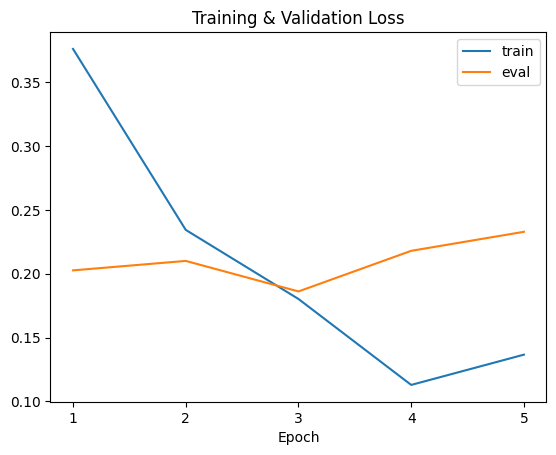

In [27]:
plt.plot(train_loss_lists, label='train')
plt.plot(eval_loss_lists, label='eval')
plt.title('Training & Validation Loss')
plt.xticks(np.arange(len(train_loss_lists)), np.arange(1, len(eval_loss_lists)+1))
plt.legend()
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

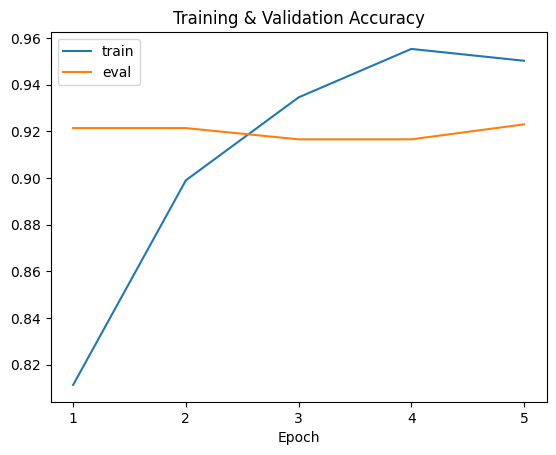

In [28]:
plt.plot(train_acc_lists, label='train')
plt.plot(eval_acc_lists, label='eval')
plt.title('Training & Validation Accuracy')
plt.xticks(np.arange(len(train_acc_lists)), np.arange(1, len(eval_acc_lists)+1))
plt.legend()
plt.xlabel('Epoch')

In [29]:
# Evaluate on test
model.eval()
torch.set_grad_enabled(False)

total_loss, total_correct, total_labels = 0, 0, 0
list_hyp, list_label = [], []

pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
    list_hyp += batch_hyp
    list_label += batch_label

# Save prediction

  0%|          | 0/39 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 39/39 [00:27<00:00,  1.43it/s]


In [ ]:
list_hyp, list_label

In [ ]:
metrics = document_sentiment_metrics_fn(list_hyp, list_label)
metrics

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(list_label, list_hyp)

cm

In [34]:
report = classification_report(list_label, list_hyp, digits=4)

print(report)

              precision    recall  f1-score   support

   ihsg naik     0.9059    0.8902    0.8980       173
  ihsg turun     0.8613    0.8806    0.8708       134

    accuracy                         0.8860       307
   macro avg     0.8836    0.8854    0.8844       307
weighted avg     0.8864    0.8860    0.8861       307

